Sample features:
     HCC     WCC   LCC    Tamb  Uin       Q
0  0.001  0.0005  0.03  253.15  1.0  1272.0
1  0.001  0.0005  0.03  273.15  1.0  1272.0
2  0.001  0.0005  0.03  293.15  1.0  1272.0
3  0.001  0.0005  0.03  313.15  1.0  1272.0
4  0.001  0.0005  0.03  253.15  1.0  3132.0
Sample targets:
0    86.117
1    89.914
2    93.532
3    96.944
4    92.271
Name: Delp, dtype: float64
Epoch [10/1000], Loss: 0.0444
Epoch [20/1000], Loss: 0.0437
Epoch [30/1000], Loss: 0.0239
Epoch [40/1000], Loss: 0.0311
Epoch [50/1000], Loss: 0.0259
Epoch [60/1000], Loss: 0.0265
Epoch [70/1000], Loss: 0.0264
Epoch [80/1000], Loss: 0.0319
Epoch [90/1000], Loss: 0.0162
Epoch [100/1000], Loss: 0.0504
Epoch [110/1000], Loss: 0.0167
Epoch [120/1000], Loss: 0.0343
Epoch [130/1000], Loss: 0.0175
Epoch [140/1000], Loss: 0.0158
Epoch [150/1000], Loss: 0.0257
Epoch [160/1000], Loss: 0.0178
Epoch [170/1000], Loss: 0.0136
Epoch [180/1000], Loss: 0.0290
Epoch [190/1000], Loss: 0.0129
Epoch [200/1000], Loss: 0.0187
Epoch

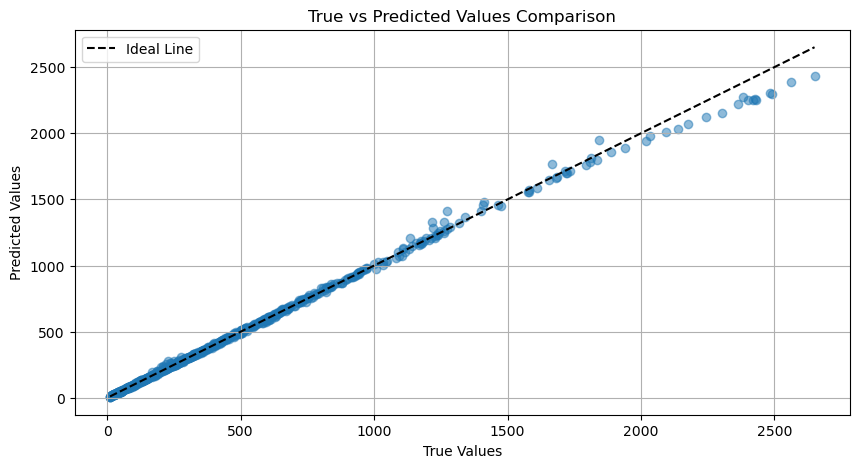

Model and scalers are saved and reloaded successfully.


In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        # Define the layers of the neural network.
        self.fc1 = nn.Linear(6, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 64)  # Second fully connected layer
        self.fc3 = nn.Linear(64, 1)    # Output layer for regression (one output)
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        # Define the forward pass through the network.
        x = self.relu(self.fc1(x))  # Pass input through first layer and apply ReLU
        x = self.relu(self.fc2(x))  # Further processing by second layer and ReLU
        x = self.fc3(x)  # Final output without activation (linear output for regression)
        return x
    
def load_and_prepare_data(filepath):
    """
    Load and prepare data from a file for training a machine learning model.

    Args:
        filepath (str): Path to the data file.

    Returns:
        tuple: Tuple containing:
            - features (DataFrame): DataFrame containing the selected features.
            - targets (Series): Series containing the target variable.

    Description:
        - Reads data from a specified file using pandas, assuming whitespace as the delimiter.
        - Skips lines starting with '%', which are treated as comments.
        - Manually sets column names to match expected features and target descriptions.
        - Extracts specific columns for use as features and a single column as the target.
        - Prints sample data to help verify correct loading and parsing.
    """
    try:
        # Attempt to read the file. The file is expected to be a whitespace-delimited text file.
        # Rows beginning with '%' are ignored, assuming they are comments.
        data = pd.read_csv(filepath, delim_whitespace=True, comment='%', header=None)
        
        # Set the column names manually as the file does not contain header information.
        data.columns = ['HCC', 'WCC', 'LCC', 'Tamb', 'Uin', 'Q',
                        'Temperature1', 'Temperature2', 'Temperature3', 'Temperature4',
                        'Temperature5', 'Temperature6', 'Pressure1', 'Pressure2', 'Delp',
                        'Velocity1', 'Velocity2', 'StackTemp1', 'StackTemp2']

    except Exception as e:
        # Handle exceptions that may occur during file reading by printing an error message
        # and returning None values for features and targets.
        print(f"Error reading the data file: {e}")
        return None, None

    # Extract features and target from the dataset based on pre-defined column labels.
    # 'feature_labels' contains the names of the columns to be used as features.
    feature_labels = ['HCC', 'WCC', 'LCC', 'Tamb', 'Uin', 'Q']
    features = data.loc[:, feature_labels]  # Select columns for features
    targets = data['Delp']  # Select the column for target

    # Output a sample of the loaded features and targets to verify correct data loading.
    print("Sample features:")
    print(features.head())  # Print the first few rows of the features to check their correct loading.
    print("Sample targets:")
    print(targets.head())  # Print the first few rows of the targets to check their correct loading.

    # Return the extracted features and targets for further use in training or analysis.
    return features, targets

def preprocess_data(features, targets):
    """
    Preprocess the features and targets: scale data and convert to tensors.

    Args:
        features (DataFrame or ndarray): The input features to be scaled.
        targets (DataFrame or Series): The target values to be scaled.

    Returns:
        tuple: Tuple containing:
            - features_tensor (Tensor): Scaled features as a tensor.
            - targets_tensor (Tensor): Scaled targets as a tensor.
            - scaler_features (StandardScaler): Scaler used for features.
            - scaler_target (StandardScaler): Scaler used for targets.

    Description:
        - This function scales the features and targets using StandardScaler to normalize data, enhancing model performance.
        - It saves the scalers for use during model evaluation to inverse transform the outputs.
        - Converts the scaled data into PyTorch tensors for model training.
    """
    # Initialize scalers for features and targets
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()

    try:
        # Scale features and fit the scaler to the features data
        features_scaled = scaler_features.fit_transform(features)
        # Scale targets and reshape if necessary to fit the scaler
        targets_scaled = scaler_target.fit_transform(targets.values.reshape(-1, 1))

        # Save the fitted scalers to disk for later use during inference
        joblib.dump(scaler_features, 'scaler_features.pkl')
        joblib.dump(scaler_target, 'scaler_target.pkl')
    except Exception as e:
        # Handle exceptions that might occur during scaling and report them
        print(f"Error scaling features or targets: {e}")
        return None, None, None  # Return None to indicate failure

    # Convert the scaled features and targets into PyTorch tensors for use in training
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
    targets_tensor = torch.tensor(targets_scaled, dtype=torch.float32).view(-1, 1)

    # Return the tensors and the scalers
    return features_tensor, targets_tensor, scaler_features, scaler_target

def prepare_loaders(features_tensor, targets_tensor, batch_size=64, test_size=0.2, random_state=42):
    """
    Prepare DataLoader objects for both training and testing datasets.
    
    Args:
        features_tensor (Tensor): A tensor containing all input features.
        targets_tensor (Tensor): A tensor containing corresponding target values.
        batch_size (int): Number of samples in each batch to load. Default is 64.
        test_size (float): The proportion of the dataset to include in the test split. Default is 0.2.
        random_state (int): Controls the shuffling applied to the data before applying the split. Default is 42.

    Returns:
        Tuple[DataLoader, DataLoader]: Returns two DataLoader objects for the training set and the test set.
    """
    # Split the data into training and testing sets using the specified proportion.
    # The random_state parameter ensures that the split is reproducible, meaning
    # the same split will occur each time the function is run with the same parameters.
    features_train, features_test, targets_train, targets_test = train_test_split(
        features_tensor, targets_tensor, test_size=test_size, random_state=random_state)

    # Create TensorDataset objects that wrap the training and testing data.
    # TensorDataset is a dataset wrapping tensors where each sample will be
    # retrieved by indexing tensors along the first dimension.
    train_dataset = TensorDataset(features_train, targets_train)
    test_dataset = TensorDataset(features_test, targets_test)

    # Create DataLoader objects for the training data and testing data.
    # DataLoader defines how data is loaded in batches. 'shuffle=True' ensures that
    # the data is shuffled at every epoch for the training data.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # For testing data, shuffling is generally not necessary.
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Return both DataLoaders to be used in the training and testing phases.
    return train_loader, test_loader

def train_model(model, train_loader, criterion, optimizer, num_epochs=1000):
    """
    Train a neural network model.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (DataLoader): DataLoader for the training data containing features and labels.
        criterion (torch.nn.modules.loss): The loss function used to evaluate the model's predictions.
        optimizer (torch.optim.Optimizer): The optimization algorithm used to update model parameters.
        num_epochs (int): Number of times the entire dataset is processed. Default is 1000.

    Procedure:
        1. The model is set to training mode, enabling specific layers like Dropout and BatchNorm.
        2. The function loops over each epoch and processes batches from the train_loader.
        3. For each batch, it performs forward pass, loss calculation, backpropagation, and parameters update.
        4. Every 10 epochs, it logs the loss to monitor training progress.
    """
    model.train()  # Set the model to training mode, which enables dropout and batch normalization layers.

    # Loop through each epoch. An epoch is one complete pass through the training dataset.
    for epoch in range(num_epochs):
        # Loop through each batch within the training loader
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Clear gradients for this training step to prevent accumulation from previous iterations
            outputs = model(inputs)  # Perform a forward pass through the model to get predictions
            loss = criterion(outputs, labels)  # Calculate loss between the predicted outputs and actual labels

            loss.backward()  # Perform backpropagation to calculate gradients
            optimizer.step()  # Update model parameters using gradients and optimizer algorithm

        # Logging the training progress
        if (epoch + 1) % 10 == 0:  # Print out the loss every 10 epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

def evaluate_model(model, test_loader, criterion, scaler_target):
    """
    Evaluate the performance of a trained neural network model.

    Args:
        model (torch.nn.Module): The neural network model to evaluate.
        test_loader (DataLoader): DataLoader for the test dataset containing features and labels.
        criterion (torch.nn.modules.loss): Loss function to measure the accuracy of the model.
        scaler_target (scaler): A pre-fitted scaler (e.g., from sklearn) used to inverse transform the model's output.

    Description:
        - The model is set to evaluation mode, which disables layers like Dropout.
        - Loss and RMSE are calculated for the entire test dataset.
        - Predictions are inverse-transformed using the scaler to bring them back to the original scale.
        - A scatter plot is generated to visually compare the true values against the predicted values.
    """
    model.eval()  # Set the model to evaluation mode. This disables Dropout, etc.
    total_loss = 0
    total_rmse = 0
    predictions, actuals = [], []

    with torch.no_grad():  # Disable gradient computation inside this block
        for inputs, labels in test_loader:
            outputs = model(inputs)  # Forward pass: compute the model output

            # Detach the outputs and labels from the graph to convert them to numpy arrays for scaling
            outputs_np = outputs.detach().cpu().numpy()
            labels_np = labels.detach().cpu().numpy()

            # Apply the inverse transform to the outputs and labels
            outputs_inv_scaled = scaler_target.inverse_transform(outputs_np.reshape(-1, 1))
            labels_inv_scaled = scaler_target.inverse_transform(labels_np.reshape(-1, 1))

            # Convert numpy arrays back to tensors for loss calculation
            outputs_tensor = torch.tensor(outputs_inv_scaled, dtype=torch.float32)
            labels_tensor = torch.tensor(labels_inv_scaled, dtype=torch.float32)

            # Calculate loss using the criterion passed to the function
            loss = criterion(outputs_tensor, labels_tensor)
            total_loss += loss.item() * inputs.size(0)  # Aggregate the total loss

            # Calculate RMSE for this batch and accumulate
            rmse = np.sqrt(mean_squared_error(labels_inv_scaled, outputs_inv_scaled))
            total_rmse += rmse * inputs.size(0)  # Aggregate the total RMSE

            # Store predictions and actuals for later plotting
            predictions.extend(outputs_inv_scaled.flatten())
            actuals.extend(labels_inv_scaled.flatten())

    # Calculate the average loss and RMSE over all batches in the test set
    mean_loss = total_loss / len(test_loader.dataset)
    mean_rmse = total_rmse / len(test_loader.dataset)
    relative_error = (mean_rmse / np.mean(actuals)) * 100  # Calculate relative error as a percentage

    # Output the calculated metrics
    print(f'Test MSE: {mean_loss:.4f}')
    print(f'Test RMSE: {mean_rmse:.4f}')
    print(f'Relative Error: {relative_error:.2f}%')

    # Plotting true values vs predicted values
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--', label='Ideal Line')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Values Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

    # The function does not need to return anything unless you wish to use the metrics outside of this function.

def main():
    # Main function to run the training and evaluation process.
    filepath = '/Users/hanheelee/Desktop/Projects/00_ML_Fuel_Cell/Set 1.txt'  # Path to data file
    features, targets = load_and_prepare_data(filepath)
    if features is None or targets is None:
        print("Failed to load data.")
        return
    
    # Process features and targets with scaling
    features_tensor, targets_tensor, scaler_features, scaler_target = preprocess_data(features, targets)
    if features_tensor is None or targets_tensor is None:
        print("Failed to preprocess data.")
        return

    # Prepare data loaders
    train_loader, test_loader = prepare_loaders(features_tensor, targets_tensor)
    
    # Create model instance
    model = RegressionNN()  # Instantiate the model
    criterion = nn.L1Loss()  # Loss function for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Optimizer
    
    # Train the model
    train_model(model, train_loader, criterion, optimizer)
    
    # Evaluate the model
    evaluate_model(model, test_loader, criterion, scaler_target)  # Pass the scaler_target to use for inverse scaling

    # Save the model's state dictionary and scalers
    torch.save(model.state_dict(), 'model.pth')
    joblib.dump(scaler_features, 'scaler_features.pkl')
    joblib.dump(scaler_target, 'scaler_target.pkl')

    # Load the model's state dictionary
    loaded_model = RegressionNN()
    loaded_model.load_state_dict(torch.load('model.pth'))
    loaded_model.eval()

    # Optionally, load and use scalers here or in another part of your application
    loaded_scaler_features = joblib.load('scaler_features.pkl')
    loaded_scaler_target = joblib.load('scaler_target.pkl')

    print("Model and scalers are saved and reloaded successfully.")

if __name__ == "__main__":
    main()  # Execute the main function if the script is run directly.